In [4]:
pip install ultralytics opencv-python albumentations tqdm torch torchvision scikit-learn Pillow pandas matplotlib seaborn


  Using cached ultralytics-8.2.59-py3-none-any.whl.metadata (41 kB)
  Using cached albumentations-1.4.11-py3-none-any.whl.metadata (39 kB)
  Using cached ultralytics_thop-2.0.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl.metadata (12 kB)
  Using cached pydantic-2.8.2-py3-none-any.whl.metadata (125 kB)
  Using cached albucore-0.0.12-py3-none-any.whl.metadata (3.1 kB)
  Using cached eval_type_backport-0.2.0-py3-none-any.whl.metadata (2.2 kB)
  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
Using cached ultralytics-8.2.59-py3-none-any.whl (802 kB)
Using cached albumentations-1.4.11-py3-none-any.whl (165 kB)
Using cached scikit_learn-1.5.1-cp311-cp311-win_amd64.whl (11.0 MB)
Using cached albucore-0.0.12-py3-none-any.whl (8.4 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
Using cached pydantic-

  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
anaconda-cloud-auth 0.1.4 requires pydantic<2.0, but you have pydantic 2.8.2 which is incompatible.


In [2]:
pip install --upgrade seaborn

   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   - -------------------------------------- 10.2/294.9 kB ? eta -:--:--
   ------------------------------ --------- 225.3/294.9 kB 3.4 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install torch torchvision

In [2]:
import torch

def check_cuda_availability():
    if torch.cuda.is_available():
        print("CUDA is available.")
        print(f"CUDA Device Name: {torch.cuda.get_device_name(0)}")
        print(f"CUDA Device Count: {torch.cuda.device_count()}")
    else:
        print("CUDA is not available.")

# Call the function
check_cuda_availability()

CUDA is available.
CUDA Device Name: NVIDIA GeForce GTX 1080
CUDA Device Count: 1


In [3]:
import os
os.environ['WANDB_DISABLED'] = 'true'
from ultralytics import YOLO
import cv2
import albumentations as A
from tqdm import tqdm
import torch
import torchvision
from torchvision import transforms
from PIL import Image
from pathlib import Path
import torchvision.models as models
import random
from collections import Counter
import shutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

E:\CodingRelated\Anaconda\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated and will be removed in a future release
  "class": algorithms.Blowfish,


In [8]:
print(torch.version.cuda)

12.1


In [12]:
# # 500 Samples. Split is 7(1/2 White BG - 1/2 Environment BG)/2/1

# def split_dataset(root_dir, output_dir, train_count=350, val_count=100, test_count=50):
#     total_count = train_count + val_count + test_count
#     train_white_bg_count = train_count // 2
#     train_env_bg_count = train_count - train_white_bg_count

#     train_dir = os.path.join(output_dir, 'train')
#     val_dir = os.path.join(output_dir, 'val')
#     test_dir = os.path.join(output_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

#     for class_dir in class_dirs:
#         class_path = os.path.join(root_dir, class_dir)
        
#         # Process White BG images for the training set
#         white_bg_path = os.path.join(class_path, 'White BG')
#         white_bg_images = []
#         if os.path.exists(white_bg_path):
#             white_bg_images = [f for f in os.listdir(white_bg_path) if os.path.isfile(os.path.join(white_bg_path, f)) and 'Discard' not in os.path.join(white_bg_path, f)]
#             random.shuffle(white_bg_images)
#             white_bg_images = white_bg_images[:train_white_bg_count]

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in white_bg_images:
#             shutil.copy(os.path.join(white_bg_path, img), os.path.join(train_dir, class_dir, f"white_bg_{img}"))

#         # Process Environmental images
#         env_path = os.path.join(class_path, 'All')
#         env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
#         random.shuffle(env_images)

#         # Ensure we have enough images
#         if len(env_images) < (train_env_bg_count + val_count + test_count):
#             print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
#             continue

#         test_images = env_images[:test_count]
#         val_images = env_images[test_count:test_count + val_count]
#         train_images = env_images[test_count + val_count:test_count + val_count + train_env_bg_count]

#         os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
#         for img in test_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
#         for img in val_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in train_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

#     print("Dataset split completed.")
#     return train_dir, val_dir, test_dir, class_dirs


In [4]:
# 500 Samples. Split is 7(1/3 White BG - 2/3 Environment BG)/2(1/3 White BG - 2/3 Environment BG)/1

def split_dataset(root_dir, output_dir, train_count=350, val_count=100, test_count=50):
    total_count = train_count + val_count + test_count
    train_white_bg_count = train_count // 3
    train_env_bg_count = train_count - train_white_bg_count
    val_white_bg_count = val_count // 3
    val_env_bg_count = val_count - val_white_bg_count

    train_dir = os.path.join(output_dir, 'train')
    val_dir = os.path.join(output_dir, 'val')
    test_dir = os.path.join(output_dir, 'test')

    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

    for class_dir in class_dirs:
        class_path = os.path.join(root_dir, class_dir)
        
        # Process White BG images for the training and validation sets
        white_bg_path = os.path.join(class_path, 'White BG')
        white_bg_images = []
        if os.path.exists(white_bg_path):
            white_bg_images = [f for f in os.listdir(white_bg_path) if os.path.isfile(os.path.join(white_bg_path, f)) and 'Discard' not in os.path.join(white_bg_path, f)]
            random.shuffle(white_bg_images)
            white_bg_train_images = white_bg_images[:train_white_bg_count]
            white_bg_val_images = white_bg_images[train_white_bg_count:train_white_bg_count + val_white_bg_count]

        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        for img in white_bg_train_images:
            shutil.copy(os.path.join(white_bg_path, img), os.path.join(train_dir, class_dir, f"white_bg_{img}"))

        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        for img in white_bg_val_images:
            shutil.copy(os.path.join(white_bg_path, img), os.path.join(val_dir, class_dir, f"white_bg_{img}"))

        # Process Environmental images
        env_path = os.path.join(class_path, 'All')
        env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
        random.shuffle(env_images)

        # Ensure we have enough images
        if len(env_images) < (train_env_bg_count + val_env_bg_count + test_count):
            print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
            continue

        test_images = env_images[:test_count]
        val_images = env_images[test_count:test_count + val_env_bg_count]
        train_images = env_images[test_count + val_env_bg_count:test_count + val_env_bg_count + train_env_bg_count]

        os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
        for img in test_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

        os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
        for img in val_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

        os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
        for img in train_images:
            shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

    print("Dataset split completed.")
    return train_dir, val_dir, test_dir, class_dirs


In [9]:
# def split_dataset(root_dir, output_dir, val_count=80, test_count=40):
#     train_dir = os.path.join(output_dir, 'train')
#     val_dir = os.path.join(output_dir, 'val')
#     test_dir = os.path.join(output_dir, 'test')

#     os.makedirs(train_dir, exist_ok=True)
#     os.makedirs(val_dir, exist_ok=True)
#     os.makedirs(test_dir, exist_ok=True)

#     class_dirs = [d for d in os.listdir(root_dir) if os.path.isdir(os.path.join(root_dir, d))]

#     for class_dir in class_dirs:
#         class_path = os.path.join(root_dir, class_dir)

#         # Process Environmental images
#         env_path = os.path.join(class_path, 'All')
#         env_images = [f for f in os.listdir(env_path) if os.path.isfile(os.path.join(env_path, f))]
#         random.shuffle(env_images)

#         # Ensure we have enough images for validation and test
#         if len(env_images) < val_count + test_count:
#             print(f"Warning: Not enough images for {class_dir}. Only {len(env_images)} available.")
#             continue

#         test_images = env_images[:test_count]
#         val_images = env_images[test_count:test_count + val_count]
#         train_images = env_images[test_count + val_count:]

#         os.makedirs(os.path.join(test_dir, class_dir), exist_ok=True)
#         for img in test_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(test_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(val_dir, class_dir), exist_ok=True)
#         for img in val_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(val_dir, class_dir, f"env_{img}"))

#         os.makedirs(os.path.join(train_dir, class_dir), exist_ok=True)
#         for img in train_images:
#             shutil.copy(os.path.join(env_path, img), os.path.join(train_dir, class_dir, f"env_{img}"))

#     print("Dataset split completed.")
#     return train_dir, val_dir, test_dir, class_dirs

In [5]:
root_dir = r"G:\SNAPFOLIA OJT SY 24 25\Dataset Versions\DATASET_3.2"
output_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG"

In [6]:
# Define the directories where your split data is stored
train_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train"
val_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val"
test_dir = r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test"

# Get the class directories from the train directory
class_dirs = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]

In [ ]:
train_dir, val_dir, test_dir, class_dirs = split_dataset(root_dir, output_dir)

In [7]:
# Initialize counters
train_counts = Counter()
val_counts = Counter()
test_counts = Counter()

# Calculate counts
for class_dir in class_dirs:
    train_counts[class_dir] = len(os.listdir(os.path.join(train_dir, class_dir)))
    val_counts[class_dir] = len(os.listdir(os.path.join(val_dir, class_dir)))
    test_counts[class_dir] = len(os.listdir(os.path.join(test_dir, class_dir)))

# Save class names in a variable
classes = [class_name for class_name in class_dirs]

# Print the counts
print("\nDataset Labels:")
print({class_name: idx for idx, class_name in enumerate(class_dirs)})

print("\nTotal Images per Class:")
for idx, class_name in enumerate(class_dirs):
    total = train_counts[class_name] + val_counts[class_name] + test_counts[class_name]
    print(f"{idx}    {class_name}: {total}")

print("\nImages per Class in TRAIN:")
for idx, (class_name, count) in enumerate(train_counts.items()):
    print(f"{idx}    {class_name}: {count}")

print("\nImages per Class in VALIDATION:")
for idx, (class_name, count) in enumerate(val_counts.items()):
    print(f"{idx}    {class_name}: {count}")

print("\nImages per Class in TEST:")
for idx, (class_name, count) in enumerate(test_counts.items()):
    print(f"{idx}    {class_name}: {count}")


Dataset Labels:
{'Acacia': 0, 'Alibangbang': 1, 'Amugis': 2, 'Apitong': 3, 'Asis': 4, 'Balayong': 5, 'Balete': 6, 'Banaba': 7, 'Bani': 8, 'Barako': 9, 'Bayabas': 10, 'Betis': 11, 'Binunga': 12, 'Dao': 13, 'Dita': 14, 'Duhat': 15, 'Eucalyptus': 16, 'Guyabano': 17, 'Hinadyong': 18, 'Ilang Ilang': 19, 'Ipil': 20, 'Kalios': 21, 'Kamagong': 22, 'Langka': 23, 'Lansones': 24, 'Madre Cacao': 25, 'Mahogany': 26, 'Mangga': 27, 'Mulawin': 28, 'Narra': 29, 'Native Talisay': 30, 'Palo Maria': 31, 'Scramble Egg': 32, 'Sintores': 33, 'Tibig': 34, 'Yakal': 35}

Total Images per Class:
0    Acacia: 679
1    Alibangbang: 500
2    Amugis: 500
3    Apitong: 500
4    Asis: 500
5    Balayong: 500
6    Balete: 500
7    Banaba: 500
8    Bani: 500
9    Barako: 500
10    Bayabas: 500
11    Betis: 500
12    Binunga: 500
13    Dao: 500
14    Dita: 500
15    Duhat: 500
16    Eucalyptus: 500
17    Guyabano: 500
18    Hinadyong: 497
19    Ilang Ilang: 500
20    Ipil: 500
21    Kalios: 497
22    Kamagong: 500
23    

In [8]:
def get_classes_from_directory(directory):
    return sorted([d.name for d in os.scandir(directory) if d.is_dir()])

def print_number_of_classes(directory):
    classes = get_classes_from_directory(directory)
    print(f"Number of classes: {len(classes)}")
    print(f"Classes: {classes}")
    
# Print the number of classes
print_number_of_classes(train_dir)

Number of classes: 36
Classes: ['Acacia', 'Alibangbang', 'Amugis', 'Apitong', 'Asis', 'Balayong', 'Balete', 'Banaba', 'Bani', 'Barako', 'Bayabas', 'Betis', 'Binunga', 'Dao', 'Dita', 'Duhat', 'Eucalyptus', 'Guyabano', 'Hinadyong', 'Ilang Ilang', 'Ipil', 'Kalios', 'Kamagong', 'Langka', 'Lansones', 'Madre Cacao', 'Mahogany', 'Mangga', 'Mulawin', 'Narra', 'Native Talisay', 'Palo Maria', 'Scramble Egg', 'Sintores', 'Tibig', 'Yakal']


In [18]:
model_path = 'yolov8n-cls.pt'

def load_model_on_cuda(model_path):
    # Load the model
    model = YOLO(model_path)
    
    # Check if CUDA is available
    if torch.cuda.is_available():
        device = torch.device('cuda')
        model.to(device)
        print(f"Model moved to {device}")
    else:
        device = torch.device('cpu')
        print(f"CUDA not available, using {device}")

    return model

model = load_model_on_cuda(model_path)

Model moved to cuda


In [19]:
model.train(data='C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG', epochs=20, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.60 available  Update with 'pip install -U ultralytics'
engine\trainer: task=classify, mode=train, model=yolov8n-cls.pt, data=C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda:0, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_cro

train: Scanning C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train... 12694 images, 2 corrupt: 100%|██████████|

train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (10).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (13).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (2).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (21).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (24).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (25).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train\Acacia\env_Acacia D (26).jpg: corrupt JPEG restored and saved
train: WARNING  C:\Snapfolia (C Drive Acce

train: New cache created: C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train.cache


val: Scanning C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val... 3650 images, 0 corrupt: 100%|██████████| 3650

val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (1).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (25).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (28).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (35).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (49).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (55).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val\Acacia\env_Acacia D (56).jpg: corrupt JPEG restored and saved
val: WARNING  C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val

val: New cache created: C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val.cache
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 26 weight(decay=0.0), 27 weight(decay=0.0005), 27 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\classify\train5
Starting training for 20 epochs...

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:55<00:00,  1.00s/it]


                   all      0.873      0.987

      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:54<00:00,  1.00it/s]

                   all       0.94      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:51<00:00,  1.03it/s]

                   all      0.955      0.998



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:51<00:00,  1.03it/s]

                   all      0.976      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:49<00:00,  1.05it/s]

                   all      0.977      0.999



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:51<00:00,  1.03it/s]

                   all      0.979          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:51<00:00,  1.03it/s]

                   all       0.98          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:53<00:00,  1.02it/s]

                   all      0.984          1



      Epoch    GPU_mem       loss  Instances       Size


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:53<00:00,  1.01it/s]

                   all      0.987      0.999



      Epoch    GPU_mem       loss  Instances       Size


      10/20      1.66G    0.08447          6        640: 100%|██████████| 794/794 [07:30<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:54<00:00,  1.01it/s]

                   all      0.983      0.999



      Epoch    GPU_mem       loss  Instances       Size


      11/20      1.65G    0.07863          6        640: 100%|██████████| 794/794 [07:24<00:00,  1.79it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:56<00:00,  1.01s/it]

                   all      0.988          1



      Epoch    GPU_mem       loss  Instances       Size


      12/20      1.66G    0.06947          6        640: 100%|██████████| 794/794 [07:30<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:49<00:00,  1.05it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      13/20      1.65G     0.0639          6        640: 100%|██████████| 794/794 [07:29<00:00,  1.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:52<00:00,  1.03it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      14/20      1.66G     0.0525          6        640: 100%|██████████| 794/794 [07:31<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:51<00:00,  1.03it/s]

                   all       0.99          1



      Epoch    GPU_mem       loss  Instances       Size


      15/20      1.65G    0.04952          6        640: 100%|██████████| 794/794 [07:37<00:00,  1.74it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:50<00:00,  1.04it/s]

                   all      0.992          1



      Epoch    GPU_mem       loss  Instances       Size


      16/20      1.66G    0.04669          6        640: 100%|██████████| 794/794 [07:28<00:00,  1.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:53<00:00,  1.01it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      17/20      1.65G    0.04202          6        640: 100%|██████████| 794/794 [07:30<00:00,  1.76it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:50<00:00,  1.04it/s]

                   all      0.991          1



      Epoch    GPU_mem       loss  Instances       Size


      18/20      1.66G    0.03666          6        640: 100%|██████████| 794/794 [07:34<00:00,  1.75it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:53<00:00,  1.01it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      19/20      1.65G    0.03964          6        640: 100%|██████████| 794/794 [07:29<00:00,  1.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:54<00:00,  1.00it/s]

                   all      0.993          1



      Epoch    GPU_mem       loss  Instances       Size


      20/20      1.66G    0.03053          6        640: 100%|██████████| 794/794 [07:27<00:00,  1.77it/s]
               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:53<00:00,  1.02it/s]

                   all      0.992          1



20 epochs completed in 3.149 hours.
Optimizer stripped from runs\classify\train5\weights\last.pt, 3.1MB
Optimizer stripped from runs\classify\train5\weights\best.pt, 3.1MB

Validating runs\classify\train5\weights\best.pt...
Ultralytics YOLOv8.2.59  Python-3.11.7 torch-2.3.1 CUDA:0 (NVIDIA GeForce GTX 1080, 8192MiB)
YOLOv8n-cls summary (fused): 73 layers, 1,480,996 parameters, 0 gradients, 3.3 GFLOPs
train: C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\train... found 12696 images in 36 classes  
val: C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\val... found 3650 images in 36 classes  
test: C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test... found 1800 images in 36 classes  


               classes   top1_acc   top5_acc: 100%|██████████| 115/115 [01:55<00:00,  1.00s/it]


                   all      0.993          1
Speed: 0.5ms preprocess, 1.1ms inference, 0.0ms loss, 0.0ms postprocess per image
Results saved to runs\classify\train5
Results saved to runs\classify\train5


ultralytics.utils.metrics.ClassifyMetrics object with attributes:

confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x00000200049BEB10>
curves: []
curves_results: []
fitness: 0.9964383542537689
keys: ['metrics/accuracy_top1', 'metrics/accuracy_top5']
results_dict: {'metrics/accuracy_top1': 0.9928767085075378, 'metrics/accuracy_top5': 1.0, 'fitness': 0.9964383542537689}
save_dir: WindowsPath('runs/classify/train5')
speed: {'preprocess': 0.4587736521681694, 'inference': 1.125406173810567, 'loss': 0.0005478401706643301, 'postprocess': 0.0}
task: 'classify'
top1: 0.9928767085075378
top5: 1.0

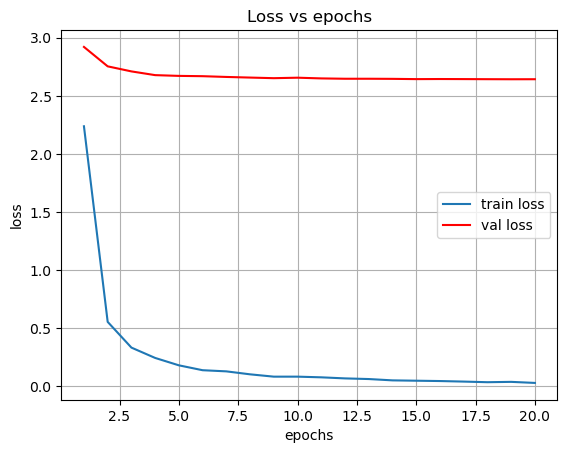

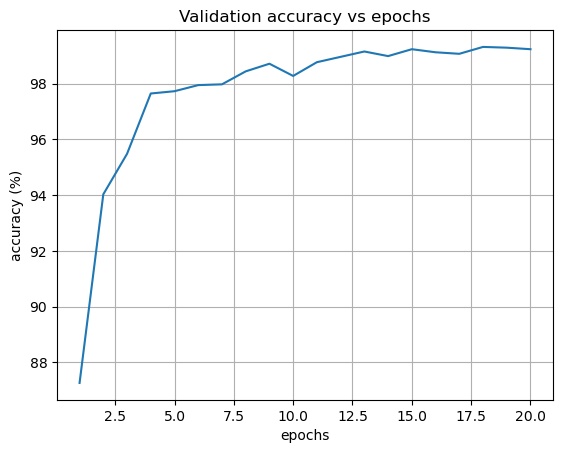

In [9]:
results_path = './runs/classify/train5/results.csv'

results = pd.read_csv(results_path)

plt.figure()
plt.plot(results['                  epoch'], results['             train/loss'], label='train loss')
plt.plot(results['                  epoch'], results['               val/loss'], label='val loss', c='red')
plt.grid()
plt.title('Loss vs epochs')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend()


plt.figure()
plt.plot(results['                  epoch'], results['  metrics/accuracy_top1'] * 100)
plt.grid()
plt.title('Validation accuracy vs epochs')
plt.ylabel('accuracy (%)')
plt.xlabel('epochs')

plt.show()

In [10]:
def generate_classification_report(run_dir, data_dir, classes):
    # Load the model
    model = YOLO(f'{run_dir}/weights/best.pt')
    
    # Prepare the test dataset
    test_dir = os.path.join(data_dir, 'test')
    test_images = []
    test_labels = []
    for class_id, class_name in enumerate(classes):
        class_dir = os.path.join(test_dir, class_name)
        for image_name in os.listdir(class_dir):
            image_path = os.path.join(class_dir, image_name)
            test_images.append(image_path)
            test_labels.append(class_id)
    
    # Predict and collect results
    y_true = []
    y_pred = []
    for image_path, label in zip(test_images, test_labels):
        predict = model(image_path)
        probs = predict[0].probs.data.tolist()
        predicted_class = np.argmax(probs)
        
        y_true.append(label)
        y_pred.append(predicted_class)
    
    # Debugging output
    print(f"Unique classes in y_true: {np.unique(y_true)}")
    print(f"Unique classes in y_pred: {np.unique(y_pred)}")
    
    # Generate classification report
    report = classification_report(y_true, y_pred, target_names=classes)
    print(report)

    return y_true, y_pred



image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test\Acacia\env_Acacia B (5).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Balayong 0.00, Binunga 0.00, Tibig 0.00, 3.0ms
Speed: 56.1ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test\Acacia\env_Acacia C (18).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Balayong 0.00, Bayabas 0.00, Tibig 0.00, 3.0ms
Speed: 53.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test\Acacia\env_Acacia C (9).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Balayong 0.00, Tibig 0.00, Binunga 0.00, 3.0ms
Speed: 52.0ms preprocess, 3.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG\test\Acacia\env_Acacia D (1).jpg: 640x640 Acacia 1.00, Scramble Egg 0.00, Balayong 0.00, 

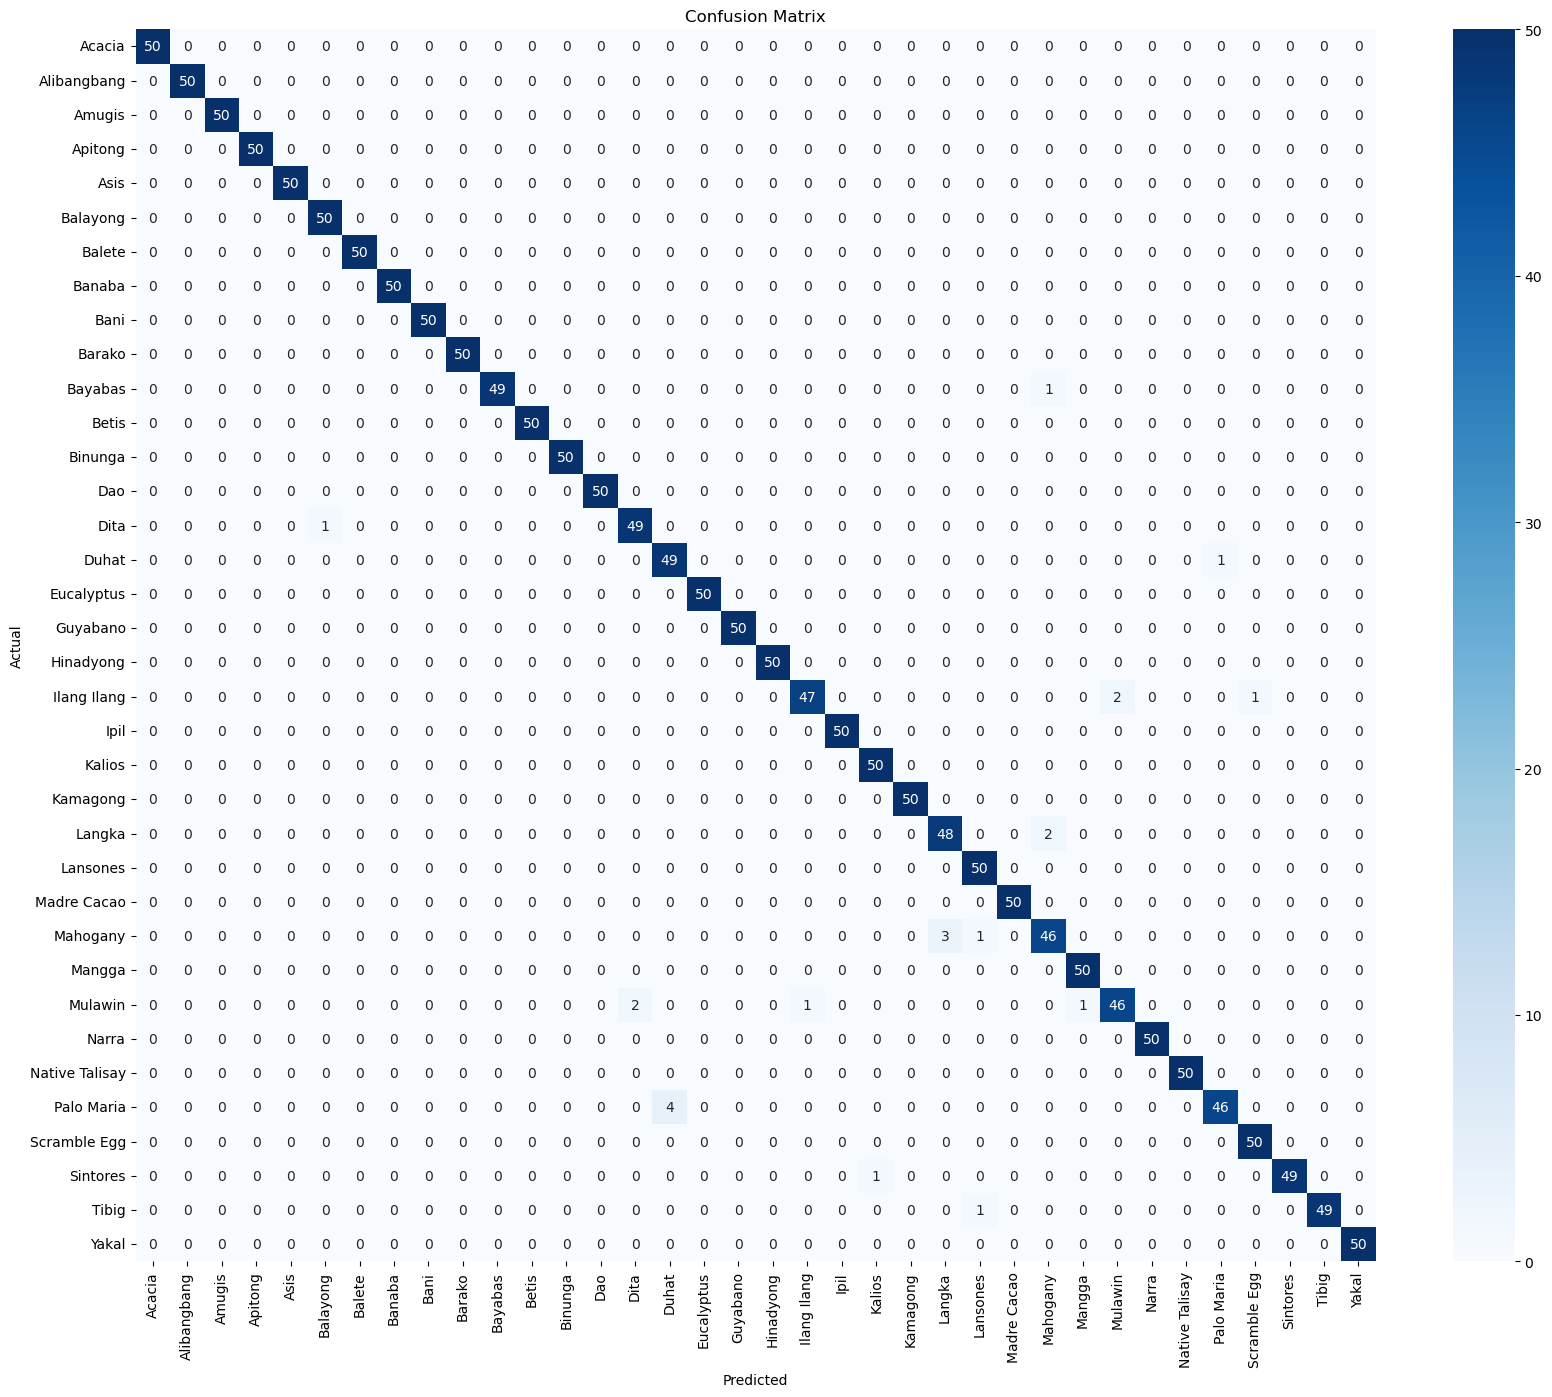

In [11]:
def generate_confusion_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(20, 16))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()
    
# Generate classification report and confusion matrix
y_true, y_pred = generate_classification_report('runs/classify/train5', r"C:\Snapfolia (C Drive Access)\Output_3.2_Env_and_WBG", classes)
generate_confusion_matrix(y_true, y_pred, classes)